# Introduction

This notebook will assign documents to domains in the data-driven ontology with the highest Dice similarity of their brain structures and mental function terms.

# Load the data

In [1]:
import pandas as pd
import numpy as np
import sys
sys.path.append("..")
import utilities, partition
from ontology import ontology

## Brain activation coordinates

In [2]:
act_bin = utilities.load_coordinates()
print("Document N={}, Structure N={}".format(
      act_bin.shape[0], act_bin.shape[1]))

Document N=18155, Structure N=118


## Document-term matrix

In [3]:
dtm_bin = utilities.load_doc_term_matrix(version=190325, binarize=True)
print("Document N={}, Term N={}".format(
      dtm_bin.shape[0], dtm_bin.shape[1]))

Document N=18155, Term N=4107


## Document splits

In [4]:
splits = {}
splits["train"] = [int(pmid.strip()) for pmid in open("../data/splits/train.txt")]
splits["validation"] = [int(pmid.strip()) for pmid in open("../data/splits/validation.txt")]
splits["test"] = [int(pmid.strip()) for pmid in open("../data/splits/test.txt")]
for split, split_pmids in splits.items():
    print("{:12s} N={}".format(split.title(), len(split_pmids)))

Train        N=12708
Validation   N=3631
Test         N=1816


In [5]:
doc2split = {}
for split, split_pmids in splits.items():
    for pmid in split_pmids:
        doc2split[pmid] = split

# Compute document distances

In [6]:
from scipy.spatial.distance import cdist

In [7]:
words = []
for k in range(2, 51):
    lists, circuits = ontology.load_ontology(k, path="../ontology/", suffix="_logreg")
    words += list(set(lists["TOKEN"]))
words = sorted(list(set(words)))
len(words)

291

In [8]:
pmids = sorted(list(dtm_bin.index.intersection(act_bin.index)))
structures = sorted(list(set(act_bin.columns)))
act_structs = act_bin.loc[pmids, structures]
dtm_words = dtm_bin.loc[pmids, words]

In [9]:
docs = dtm_words.copy()
docs[structures] = act_structs.copy()
docs.head()

,action,addiction,affective_picture,air_hunger,anger,anhedonia,anticipation,anxiety,arm,arousal,...,right_superior_temporal_gyrus_posterior_division,right_supplementary_motor_cortex,right_supracalcarine_cortex,right_supramarginal_gyrus_anterior_division,right_supramarginal_gyrus_posterior_division,right_temporal_fusiform_cortex_anterior_division,right_temporal_fusiform_cortex_posterior_division,right_temporal_occipital_fusiform_cortex,right_temporal_pole,right_thalamus
1402966,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0,0,0,0,0,0,0,1,0,0
1410086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,1,0,0
1448149,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0,0,0,0,0,0,0,0,1,0
1486459,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,0,0,0,0,0,0,0,0
1486460,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,1,0,0,0,0,0


In [10]:
doc_dists = cdist(docs, docs, metric="dice")
doc_dists = pd.DataFrame(doc_dists, index=pmids, columns=pmids)

In [11]:
ordered_pmids = []
for split, split_pmids in splits.items():
    ordered_pmids += sorted(split_pmids)
doc_dists = doc_dists[ordered_pmids].loc[ordered_pmids]

In [12]:
transitions = []
for i, pmid in enumerate(ordered_pmids):
    if doc2split[ordered_pmids[i-1]] != doc2split[pmid]:
        transitions.append(i)

# Plot document distances

In [13]:
import matplotlib.pyplot as plt
from matplotlib import cm, font_manager, rcParams

%matplotlib inline

In [14]:
linewidth=1.5
rcParams["axes.linewidth"] = linewidth

In [15]:
t1, t2 = transitions[1], transitions[2]
doc_dists_filtered = doc_dists.values.copy()
doc_dists_filtered[:t1,t1:] = np.nan
doc_dists_filtered[t1:,:t1] = np.nan
doc_dists_filtered[t1:t2,t2:] = np.nan
doc_dists_filtered[t2:,t1:t2] = np.nan

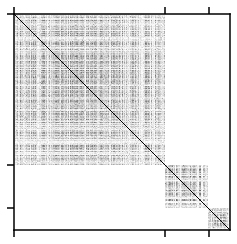

In [16]:
fig = plt.figure(figsize=(3,3))
ax = fig.add_axes([0,0,1,1])

X = doc_dists_filtered.astype(np.float)
im = ax.matshow(X, cmap=cm.Greys_r, vmin=0, vmax=1, alpha=1) 
plt.xticks(transitions)
plt.yticks(transitions)
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.xaxis.set_tick_params(width=linewidth, length=7)
ax.yaxis.set_tick_params(width=linewidth, length=7)

plt.savefig("figures/partition_splits.png", 
            dpi=250, bbox_inches="tight")
plt.show()
plt.close()